<a href="https://colab.research.google.com/github/nakuluttarkar/Fake-news-categorizer/blob/main/fakeNewsCategorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LsiModel, TfidfModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
plt.rcParams['figure.figsize'] = (10, 8)
default_plot_color = "#00bfbf"

In [ ]:
data = pd.read_csv("fake_news_data.csv")
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


<Axes: xlabel='fake_or_factual'>

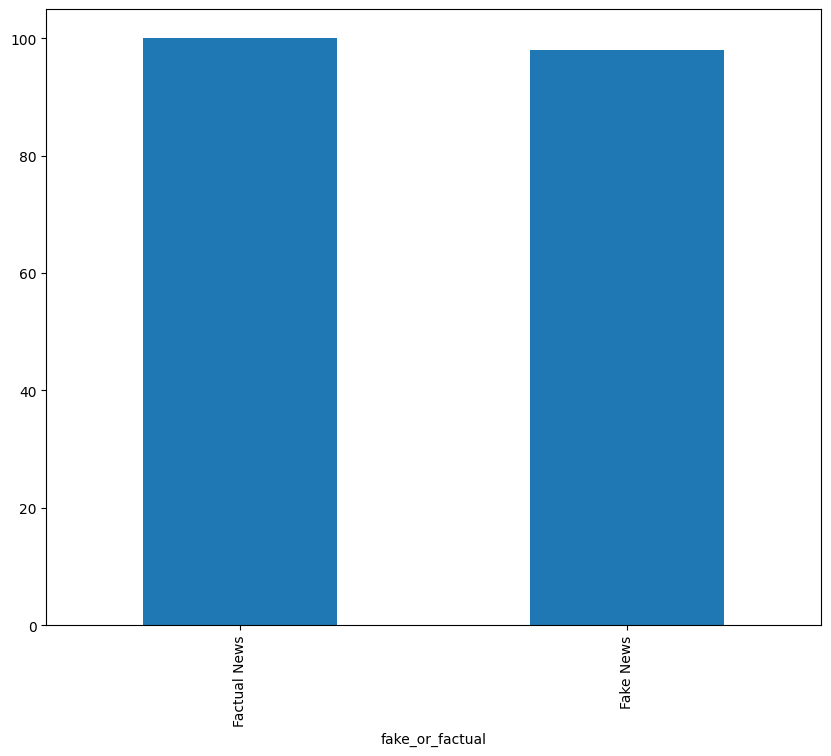

In [ ]:
data['fake_or_factual'].value_counts().plot(kind='bar')

# POS Tagging


In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
factual_news = data[data['fake_or_factual'] == 'Factual News']

In [ ]:
fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(factual_news['text']))


In [ ]:
fake_spacydocs[:2]

[There are two small problems with your analogy Susan  Jesus was NOT a Muslim and Joseph traveled to Bethlehem with Mary. For anyone who s not paying attention there don t appear to be many female refugees accompanying male Muslim  refugees  to Greece.Susan Sarandon spent the Christmas holiday on the Greek island of Lesbos assisting international organizations with the mounting Syrian refugee crisis   a crisis, she says, that recalls the travails of Joseph and Mary on their way to the Inn in Bethlehem.In a column for the Huffington Post and RYOT, the 69-year-old Oscar-winning actress described meeting a 16-year-old girl who had apparently given birth shortly before arriving on the island. I smile and approach her, but without a translator, our conversation is basic-friendly,  Sarandon wrote of her experience.  She takes the bundle next to her and opens it to me. Inside is a perfect, rosy, newborn. The actress continues:She is beaming, so proud. How did this young girl, just having give

In [ ]:
fact_spacydocs[0]

WASHINGTON (Reuters) - U.S. Defense Secretary Jim Mattis said on Monday that Russia s bombing of U.S-backed fighters in Syria was being discussed at the highest levels and while a communication link between the two countries had worked to avoid such incidents, the strike over the weekend was a departure.  When you look at the fact that this is a change, you can imagine this is at the highest levels,  Mattis told reporters. Russia s Defense Ministry on Sunday rejected the allegations, saying its planes only targeted Islamic State militants and that it had warned the United States well in advance of its operational plans. 

In [ ]:
def extract_tags(doc:spacy.tokens.doc.Doc):
  return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [ ]:
fake_tagsdf = []
column = ['token', 'ner_tag', 'pos_tag']

In [ ]:
for ix, doc in enumerate(fake_spacydocs):
  tags = extract_tags(doc)
  tags = pd.DataFrame(tags)
  tags.columns = column
  fake_tagsdf.append(tags)
fake_tagsdf = pd.concat(fake_tagsdf)

In [ ]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


TypeError: cannot concatenate object of type '<class 'str'>'; only Series and DataFrame objs are valid

In [ ]:
fact_tagsdf = []
for ix, doc in enumerate(fact_spacydocs):
  tags = extract_tags(doc)
  tags = pd.DataFrame(tags)
  tags.columns = column
  fact_tagsdf.append(tags)
fact_tagsdf = pd.concat(fact_tagsdf, ignore_index=True)

In [ ]:
fact_tagsdf.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [ ]:
pos_count_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='count').sort_values('count', ascending=False)
pos_count_fake.head(10)

,token,pos_tag,count
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [ ]:
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [ ]:
pos_counts_fact[pos_counts_fact['pos_tag'] == 'VERB'][:10]

,token,pos_tag,counts
5567,said,VERB,451
6210,told,VERB,55
3841,have,VERB,43
6649,’s,VERB,35
4021,including,VERB,33
4410,make,VERB,31
4395,made,VERB,29
6072,take,VERB,28
3168,do,VERB,25
5582,saying,VERB,24


In [ ]:
pos_count_fake[pos_count_fake['pos_tag'] == 'NOUN'][:10]

,token,pos_tag,count
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


# Named Entities

In [ ]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ''].groupby(['token', 'ner_tag']).size().reset_index(name='count').sort_values('count', ascending=False)
top_entities_fake.head(10)

,token,ner_tag,count
1730,Trump,PERSON,154
1729,Trump,ORG,152
2129,the,ORG,121
592,Clinton,PERSON,118
718,Donald,PERSON,75
890,Hillary,PERSON,64
1329,Obama,PERSON,59
1179,McCain,PERSON,53
2167,year,DATE,44
1662,Syria,GPE,42


In [ ]:
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ''].groupby(['token', 'ner_tag']).size().reset_index(name='count').sort_values('count', ascending=False)
top_entities_fact.head(10)

,token,ner_tag,count
1968,the,ORG,159
1633,U.S.,GPE,138
1373,Reuters,ORG,131
1615,Trump,PERSON,125
1614,Trump,ORG,124
882,House,ORG,67
1997,year,DATE,63
1646,United,GPE,59
1965,the,GPE,59
1254,Obama,PERSON,55


[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

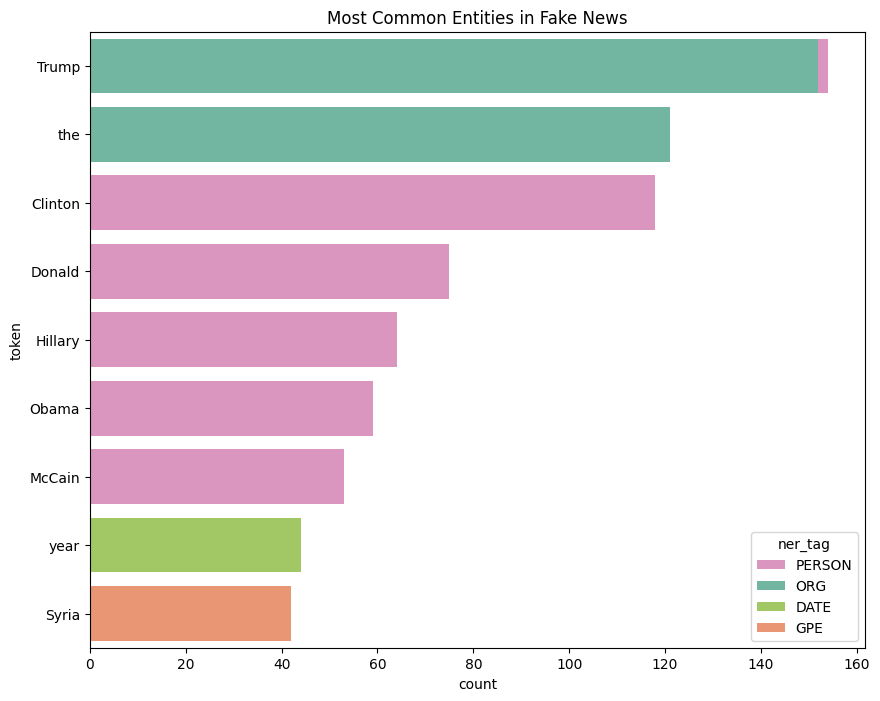

In [ ]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}
sns.barplot(
    x = 'count',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

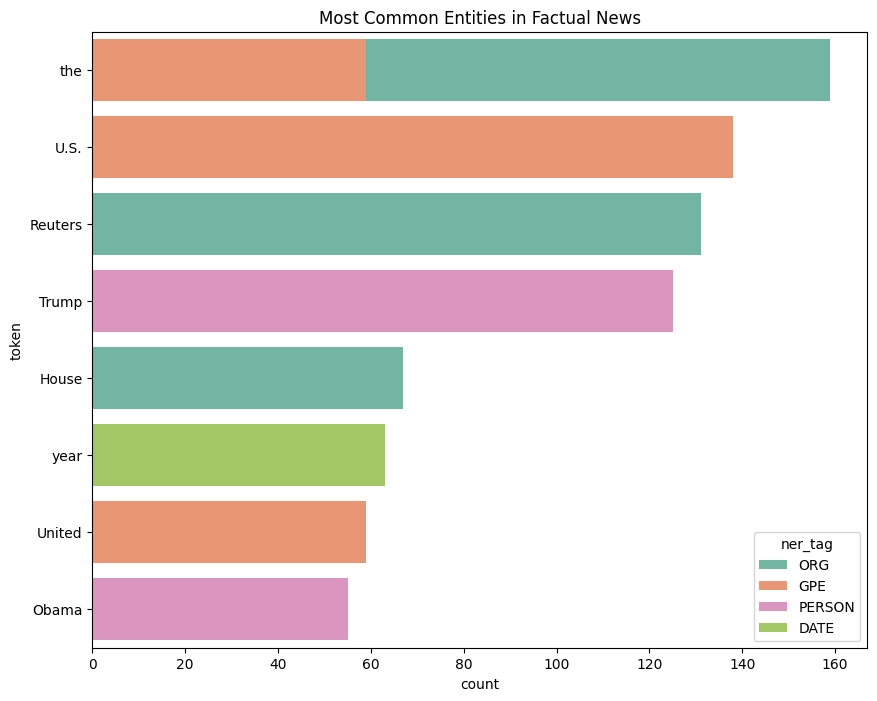

In [ ]:
sns.barplot(
    x = 'count',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Factual News')

In [ ]:
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1)

In [ ]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,year-old Oscar-winning actress described meeti...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


In [ ]:
data['text_clean'] = data['text_clean'].str.lower()
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x["text_clean"]), axis = 1)
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,yearold oscarwinning actress described meeting...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make up over 50 percent of this country ...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said on monday...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...


In [ ]:
en_stopwords = stopwords.words('english')
print(en_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [ ]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))

In [ ]:
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)

In [ ]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[women, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[us, defense, secretary, jim, mattis, said, mo..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, parties, rapidl..."


In [ ]:
lemmatizer = WordNetLemmatizer()
data["text_clean"] = data["text_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])

In [ ]:
tokens_clean = sum(data['text_clean'], [])
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts()).reset_index()[:10]
print(unigrams)

           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


In [ ]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts()).reset_index()[:10]
print(bigrams)

                 index  count
0      (donald, trump)     92
1      (united, state)     80
2       (white, house)     72
3  (president, donald)     42
4   (hillary, clinton)     31
5          (new, york)     31
6         (image, via)     29
7     (supreme, court)     29
8     (official, said)     26
9        (food, stamp)     24


# Sentiment Analyser

In [ ]:
vader_sentiment = SentimentIntensityAnalyzer()
data['vader_sentiment_score'] = data['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'])
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [ ]:
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']
data['vader_sentiment'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<Axes: xlabel='vader_sentiment'>

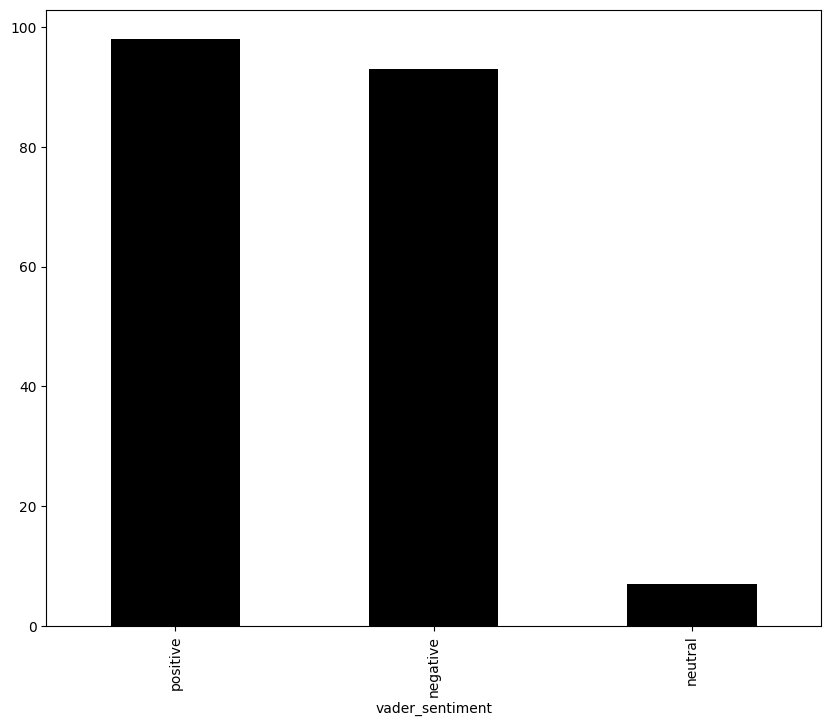

In [ ]:
data['vader_sentiment'].value_counts().plot.bar(color='black')

# Topic Modelling

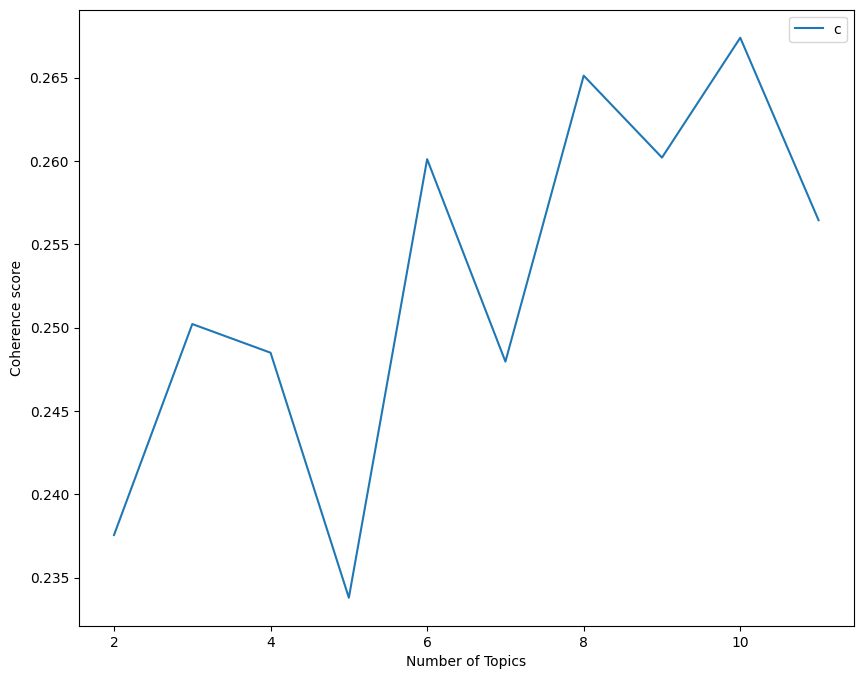

In [ ]:
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True)
dictionary_fake = corpora.Dictionary(fake_news_text) #{'president': 0, 'trump':1, ... } Creates a dictionary with words and assigns index
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text] #Creating bag_of_words, [(0,3), (1,2), ...] , this represents -> 0th index word('president') appears 3 times
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())

plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
num_topics_fake = 6
lda_model_fake = gensim.models.LdaModel(corpus=doc_term_fake, num_topics=num_topics_fake, id2word = dictionary_fake)
lda_model_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.008*"trump" + 0.007*"would" + 0.004*"republican" + 0.004*"president" + 0.003*"said" + 0.003*"student" + 0.003*"one" + 0.003*"image" + 0.003*"u" + 0.003*"also"'),
 (1,
  '0.015*"trump" + 0.004*"said" + 0.004*"clinton" + 0.003*"year" + 0.003*"president" + 0.003*"state" + 0.003*"one" + 0.003*"u" + 0.003*"donald" + 0.003*"woman"'),
 (2,
  '0.006*"clinton" + 0.005*"woman" + 0.004*"trump" + 0.004*"people" + 0.004*"syria" + 0.003*"one" + 0.003*"said" + 0.003*"republican" + 0.003*"mccain" + 0.003*"hillary"'),
 (3,
  '0.013*"trump" + 0.006*"clinton" + 0.006*"said" + 0.005*"state" + 0.005*"u" + 0.005*"time" + 0.004*"woman" + 0.004*"obama" + 0.004*"president" + 0.003*"email"'),
 (4,
  '0.018*"trump" + 0.005*"said" + 0.004*"republican" + 0.004*"state" + 0.004*"president" + 0.003*"one" + 0.003*"donald" + 0.003*"time" + 0.003*"like" + 0.003*"also"'),
 (5,
  '0.006*"said" + 0.005*"trump" + 0.005*"president" + 0.004*"u" + 0.004*"state" + 0.004*"time" + 0.004*"mccain" + 0.003*"one" + 0.003*"n

# TF-IDF and LSA

In [ ]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vecotization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [ ]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

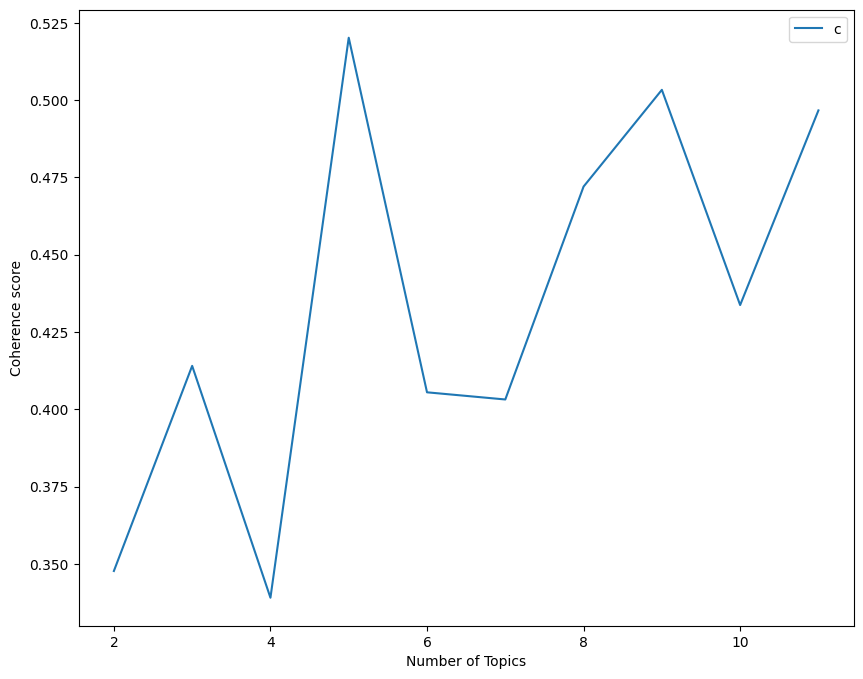

In [ ]:
# create tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake)
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)


In [ ]:
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '0.218*"trump" + 0.135*"clinton" + 0.094*"woman" + 0.087*"president" + 0.086*"republican" + 0.085*"obama" + 0.084*"party" + 0.083*"school" + 0.081*"said" + 0.079*"time"'),
 (1,
  '0.299*"boiler" + 0.253*"room" + 0.250*"acr" + 0.186*"jay" + 0.185*"animal" + 0.176*"episode" + 0.147*"analysis" + 0.122*"dyer" + 0.119*"savant" + 0.119*"moralist"'),
 (2,
  '-0.219*"school" + 0.195*"clinton" + 0.163*"conference" + -0.151*"county" + -0.137*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love" + 0.095*"email"'),
 (3,
  '0.375*"flynn" + 0.151*"russian" + 0.111*"email" + 0.109*"30" + 0.101*"department" + 0.100*"information" + 0.100*"nana" + 0.099*"official" + 0.098*"mccain" + -0.096*"trump"'),
 (4,
  '0.235*"trump" + 0.223*"flynn" + 0.166*"conference" + -0.165*"clinton" + -0.153*"dnc" + -0.151*"sander" + -0.127*"email" + 0.111*"press" + -0.109*"rich" + 0.084*"tax"')]

# Predict Fake or factual news

In [ ]:
X = [','.join(map(str, l)) for l in data['text_clean']]
Y = data['fake_or_factual']

In [ ]:
countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)
bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())
bag_of_words

,01,03,05,08441,10,100,1000,10000,1000000000000000,1002,...,zimbabwe,zimbabwean,zimmerman,zina,zionism,zoe,zone,zoom,zouka,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
194,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [ ]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [ ]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [ ]:
y_pred_lr = lr.predict(X_test)

In [ ]:
accuracy_score(y_pred_lr, y_test)

0.85

In [ ]:
svm = SGDClassifier().fit(X_train, y_train)

In [ ]:
y_pred_svm = svm.predict(X_test)

In [ ]:
accuracy_score(y_pred_svm, y_test)

0.9